## <center>Bangla Handwritten Math Solver<center> 

In [1]:
# calculate total execution time

from datetime import datetime
start_time = datetime.now()

print('Duration: {}'.format(start_time))

Duration: 2022-10-15 19:06:09.703109


## Importing Libraries

In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours
from keras.models import load_model

## Loading the Dataset 

In [3]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    print(folder + '....')
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

0....
1....
2....
3....
4....
5....
6....
7....
8....
9....
add....
div....
mul....
sub....
294628
294628
labels : ['4', '5', 'sub', '3', '1', '6', '9', '2', 'div', 'add', '0', '8', '7', 'mul']
Duration: 0:18:49.037000


## Visualizing Images in the Dataset 

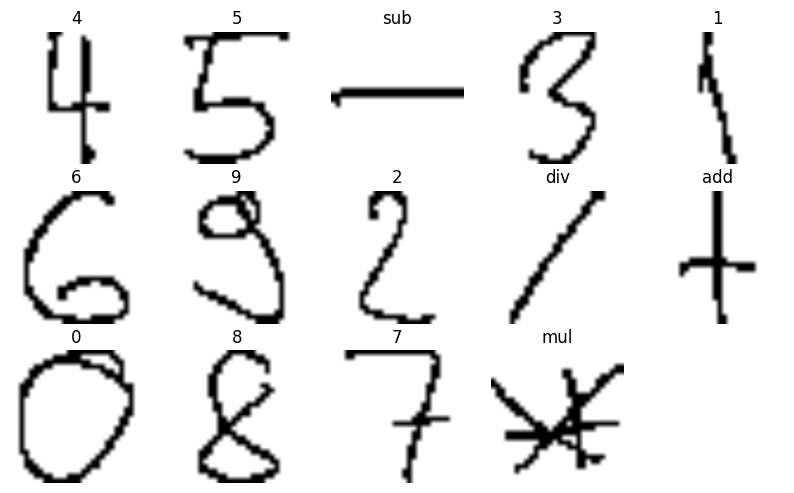

In [4]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Data Distribution of the Dataset 

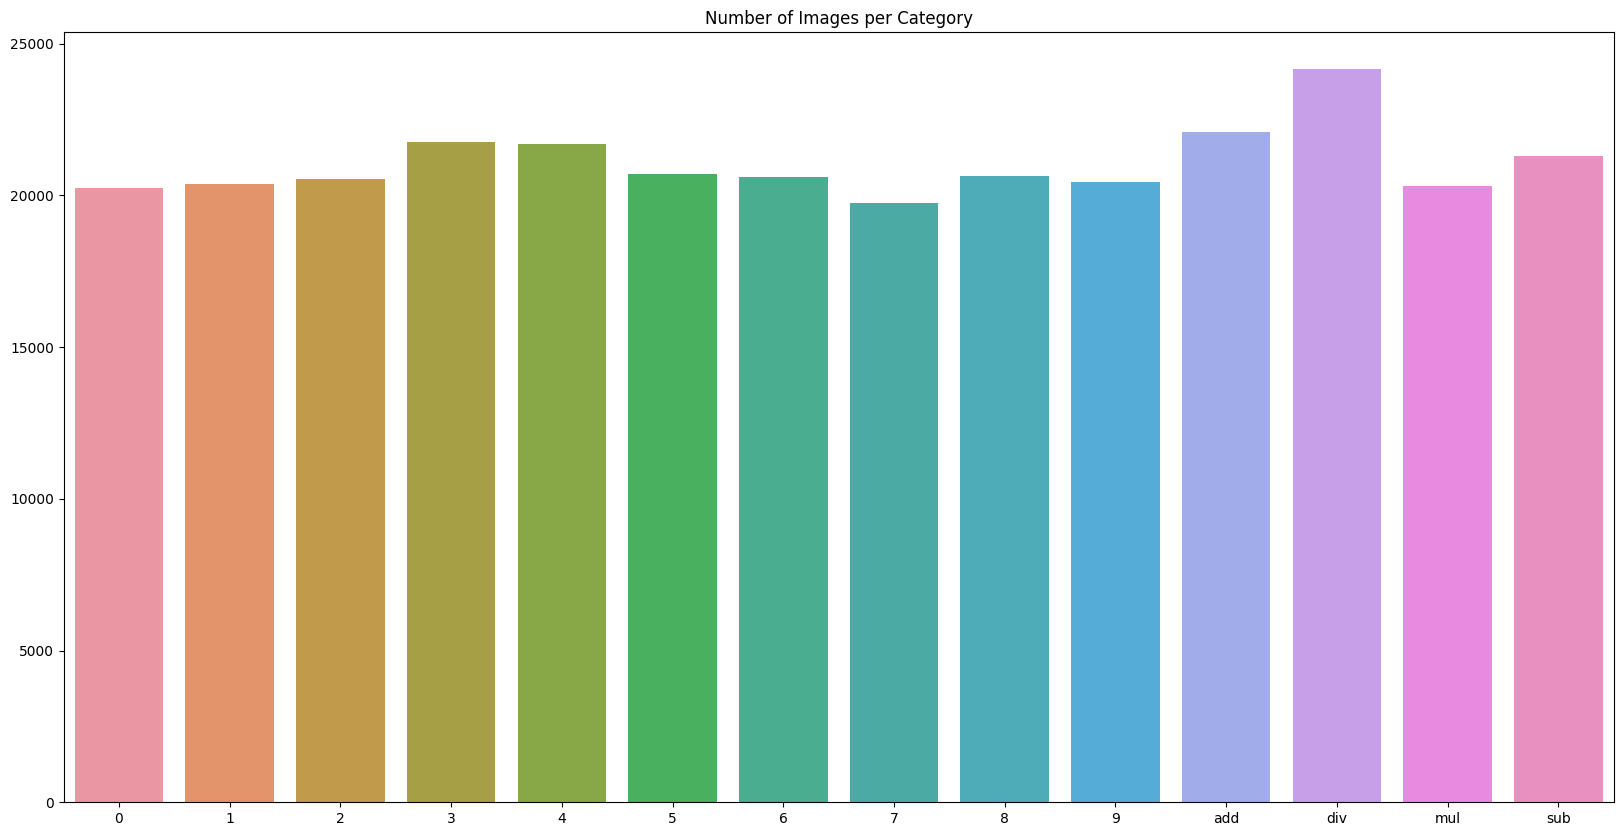

In [5]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique, y=count).set_title('Number of Images per Category')
plt.show()

In [6]:
# the dataset is not much imbalanced. So balancing is not required here much.

## Preprocessing the Data

In [7]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

294628
Duration: 0:18:54.234071


In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

294628
Duration: 0:18:54.342932


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

print(len(Y_train))
print(len(Y_test))

235702
58926
235702
58926


## Data Distribution in Train

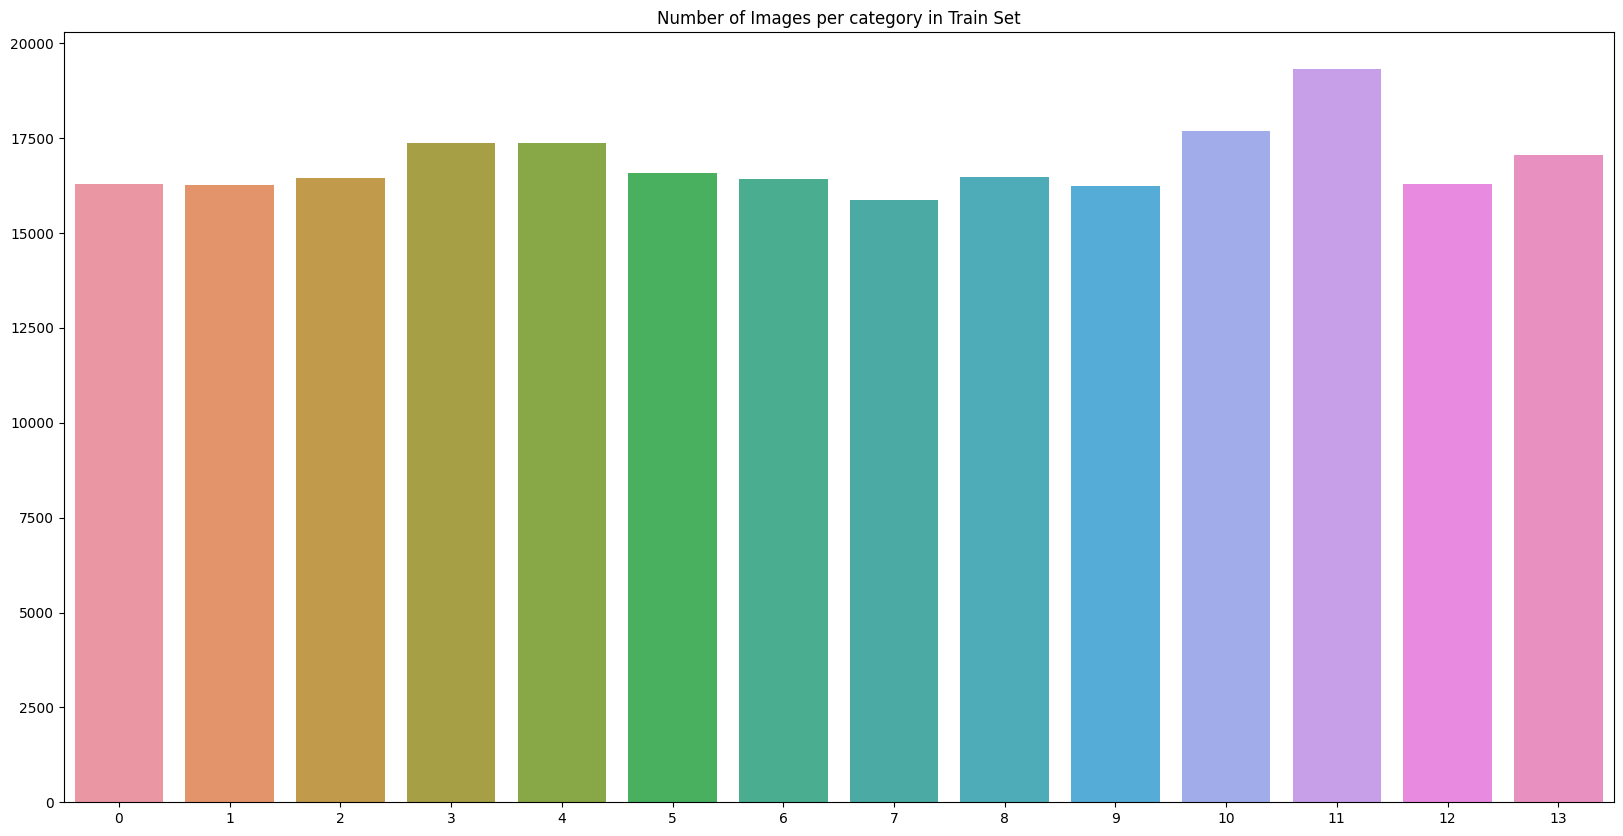

In [10]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_train, y=count_train).set_title('Number of Images per category in Train Set')
plt.show()

## Data Distribution in Test Set

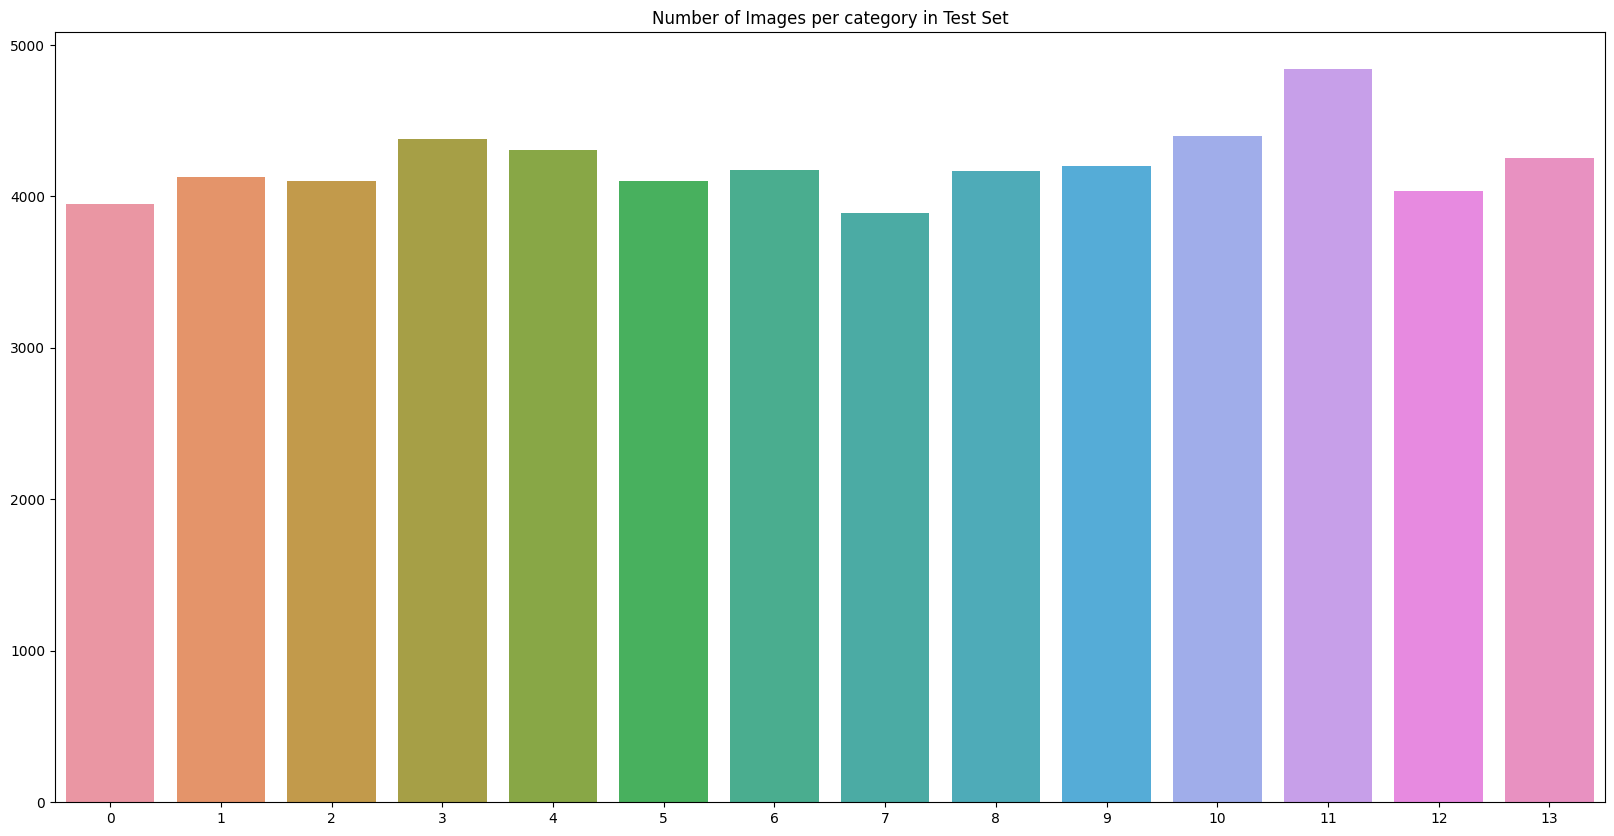

In [11]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_test, y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

## Defining the Model 

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(235702, 32, 32, 1)
(58926, 32, 32, 1)
(235702, 14)
(58926, 14)


In [13]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [14]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

##  Training the Model

In [15]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('math_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:18:56.923876


In [16]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/100
1842/1842 [==============================] - 229s 124ms/step - loss: 0.5476 - accuracy: 0.8629 - val_loss: 0.2364 - val_accuracy: 0.9558
Epoch 2/100
1842/1842 [==============================] - 255s 139ms/step - loss: 0.2586 - accuracy: 0.9339 - val_loss: 0.1879 - val_accuracy: 0.9632
Epoch 3/100
1842/1842 [==============================] - 246s 133ms/step - loss: 0.2085 - accuracy: 0.9464 - val_loss: 0.1408 - val_accuracy: 0.9715
Epoch 4/100
1842/1842 [==============================] - 250s 136ms/step - loss: 0.1842 - accuracy: 0.9526 - val_loss: 0.1356 - val_accuracy: 0.9725
Epoch 5/100
1842/1842 [==============================] - 246s 134ms/step - loss: 0.1689 - accuracy: 0.9564 - val_loss: 0.1169 - val_accuracy: 0.9772
Epoch 6/100
1842/1842 [==============================] - 239s 130ms/step - loss: 0.1587 - accuracy: 0.9593 - val_loss: 0.1295 - val_accuracy: 0.9756
Epoch 7/100
1842/1842 [==============================] - 278s 151ms/step - loss: 0.1538 - accuracy: 0.9606

Epoch 56/100
1842/1842 [==============================] - 249s 135ms/step - loss: 0.1066 - accuracy: 0.9742 - val_loss: 0.0752 - val_accuracy: 0.9871
Epoch 57/100
1842/1842 [==============================] - 247s 134ms/step - loss: 0.1043 - accuracy: 0.9747 - val_loss: 0.0770 - val_accuracy: 0.9858
Epoch 58/100
1842/1842 [==============================] - 240s 130ms/step - loss: 0.1055 - accuracy: 0.9742 - val_loss: 0.0862 - val_accuracy: 0.9858
Epoch 59/100
1842/1842 [==============================] - 234s 127ms/step - loss: 0.1061 - accuracy: 0.9744 - val_loss: 0.0813 - val_accuracy: 0.9871
Epoch 60/100
1842/1842 [==============================] - 264s 143ms/step - loss: 0.1056 - accuracy: 0.9741 - val_loss: 0.0725 - val_accuracy: 0.9868
Epoch 61/100
1842/1842 [==============================] - 267s 145ms/step - loss: 0.1045 - accuracy: 0.9746 - val_loss: 0.0773 - val_accuracy: 0.9852
Epoch 62/100
1842/1842 [==============================] - 267s 145ms/step - loss: 0.1050 - accuracy:

##  Loss and Accuracy Plot

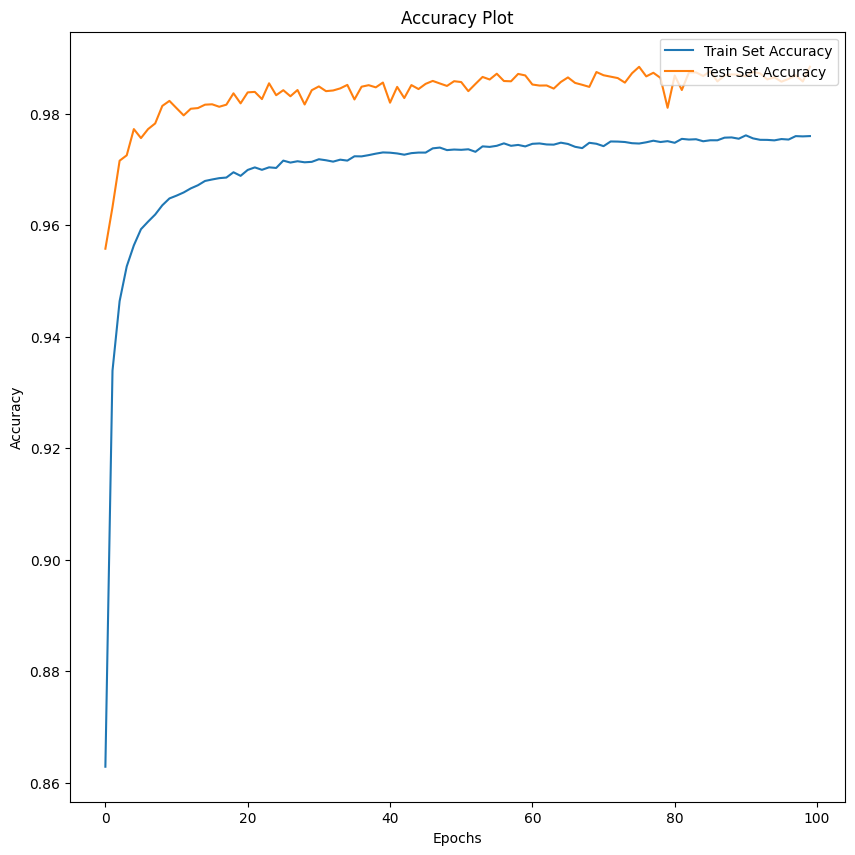

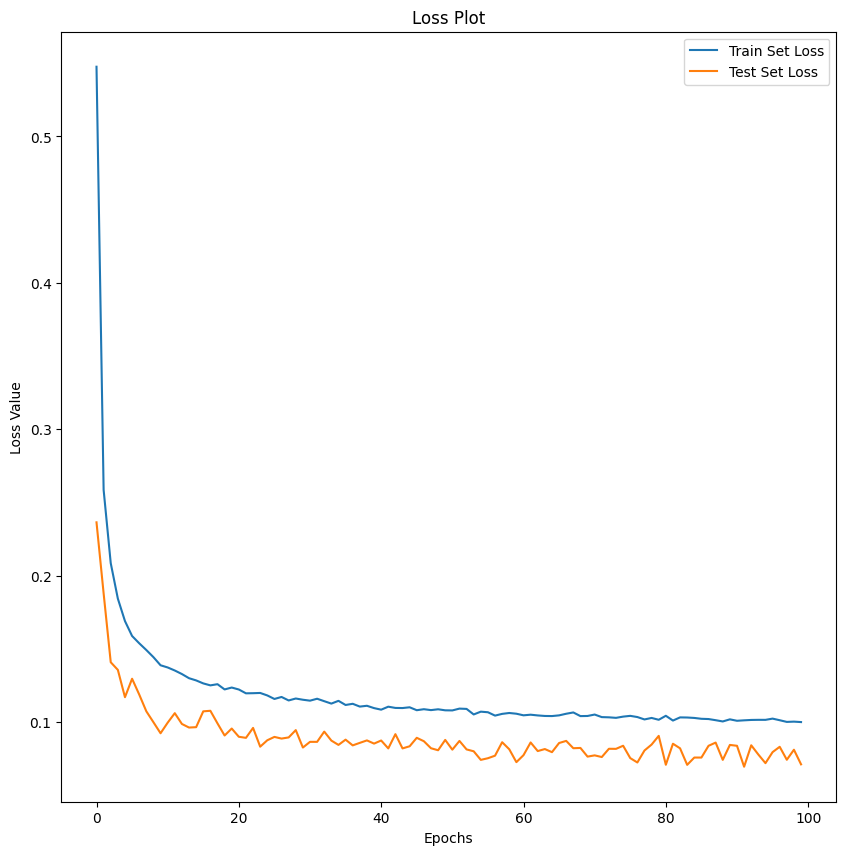

In [17]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix 

1842/1842 [==============================] - 15s 8ms/step


<AxesSubplot: >

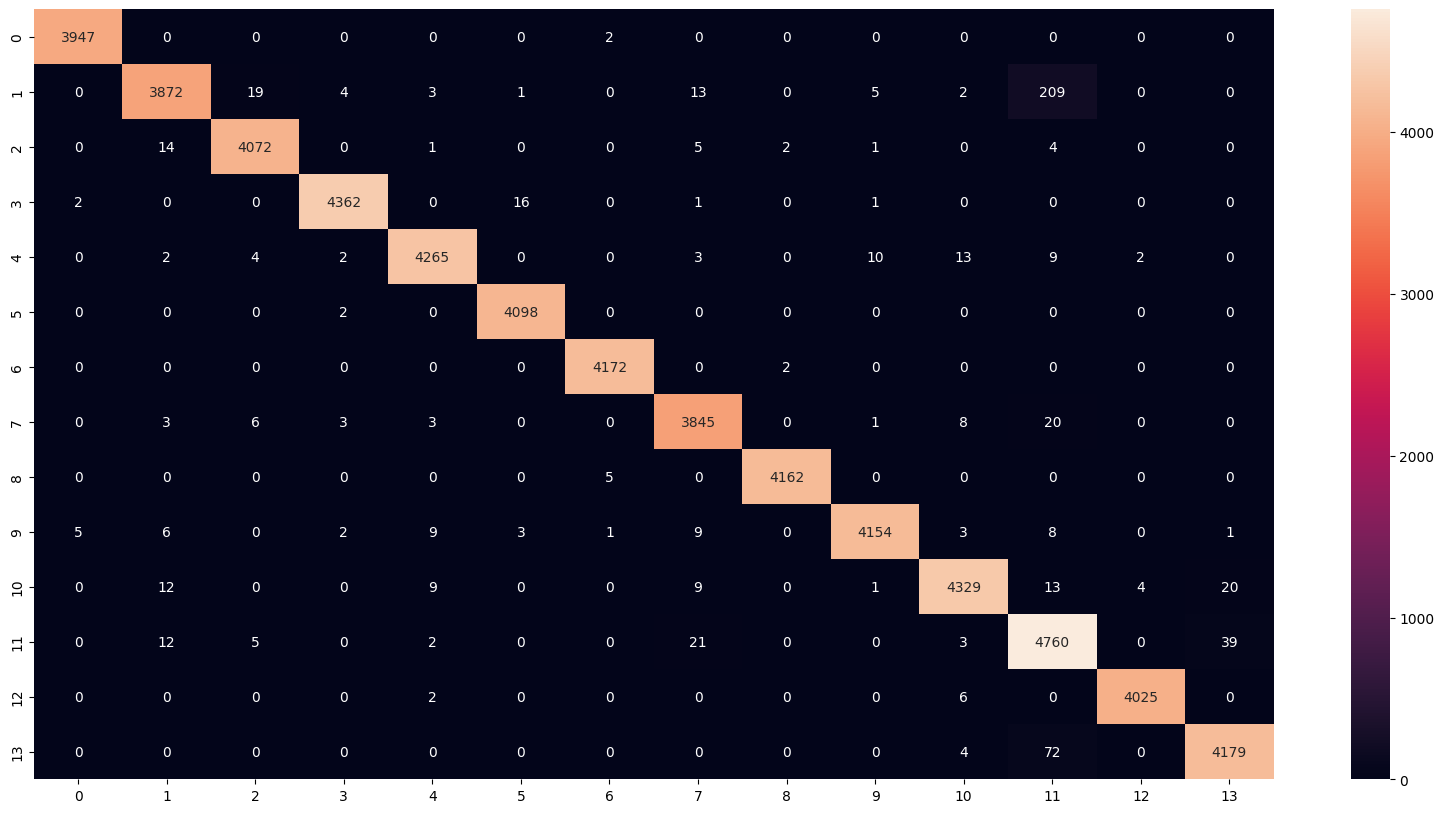

In [18]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)

matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sb.heatmap(df_cm, annot=True, fmt='d')

## Classification Report

In [19]:
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3949
           1       0.99      0.94      0.96      4128
           2       0.99      0.99      0.99      4099
           3       1.00      1.00      1.00      4382
           4       0.99      0.99      0.99      4310
           5       1.00      1.00      1.00      4100
           6       1.00      1.00      1.00      4174
           7       0.98      0.99      0.99      3889
           8       1.00      1.00      1.00      4167
           9       1.00      0.99      0.99      4201
          10       0.99      0.98      0.99      4397
          11       0.93      0.98      0.96      4842
          12       1.00      1.00      1.00      4033
          13       0.99      0.98      0.98      4255

    accuracy                           0.99     58926
   macro avg       0.99      0.99      0.99     58926
weighted avg       0.99      0.99      0.99     58926



## Saving the Model 

In [20]:
model.save('math_symbol_and_digit_recognition.h5')

## Total Execution Time

In [21]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 7:56:23.535636


## Testing the Model 

In [22]:
def test_pipeline(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [23]:
# test_pipeline('test_data/test.jpg')

In [24]:
# test_pipeline('test_data/test_2.jpg')

In [25]:
def test_pipeline_equation(image_path):
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            chars.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    e = ''
    for i in chars:
        if i=='add':
            e += '+'
        elif i=='sub':
            e += '-'
        elif i=='mul':
            e += '*'
        elif i=='div':
            e += '/'
        else:
            e += i
    v = eval(e)
    print('V Result: {}', v)
    print('E Result: {}', e)
    print('Value of the expression {} : {}'.format(e, v)) 

In [26]:
# test_pipeline_equation('test_data/test_equation_2.jpg')